In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_models/ukb_FIS.csv', index_col=0)

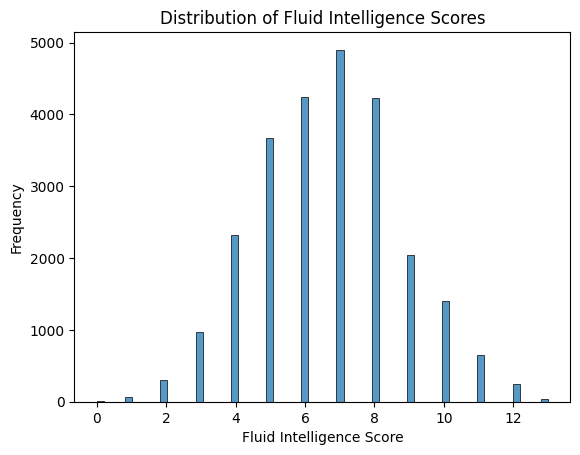

In [3]:
# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'])
plt.title('Distribution of Fluid Intelligence Scores')
plt.xlabel('Fluid Intelligence Score')
plt.ylabel('Frequency')
plt.show()

In [4]:
print(len(df))

25095


##### Using MIND to predict Fluid Intelligence Score

In [6]:
# Set X and y

X = df[['31-0.0', '21003-2.0',
        
        'lh_bankssts', 'lh_caudalanteriorcingulate', 'lh_caudalmiddlefrontal',
        'lh_cuneus', 'lh_entorhinal', 'lh_fusiform', 'lh_inferiorparietal', 
        'lh_inferiortemporal', 'lh_isthmuscingulate', 'lh_lateraloccipital', 
        'lh_lateralorbitofrontal', 'lh_lingual', 'lh_medialorbitofrontal', 
        'lh_middletemporal', 'lh_parahippocampal', 'lh_paracentral', 
        'lh_parsopercularis', 'lh_parsorbitalis', 'lh_parstriangularis', 
        'lh_pericalcarine', 'lh_postcentral', 'lh_posteriorcingulate', 
        'lh_precentral', 'lh_precuneus', 'lh_rostralanteriorcingulate', 
        'lh_rostralmiddlefrontal', 'lh_superiorfrontal', 'lh_superiorparietal', 
        'lh_superiortemporal', 'lh_supramarginal', 'lh_frontalpole', 
        'lh_temporalpole', 'lh_transversetemporal', 'lh_insula', 
        'rh_bankssts', 'rh_caudalanteriorcingulate', 'rh_caudalmiddlefrontal', 
        'rh_cuneus', 'rh_entorhinal', 'rh_fusiform', 'rh_inferiorparietal', 
        'rh_inferiortemporal', 'rh_isthmuscingulate', 'rh_lateraloccipital', 
        'rh_lateralorbitofrontal', 'rh_lingual', 'rh_medialorbitofrontal', 
        'rh_middletemporal', 'rh_parahippocampal', 'rh_paracentral', 
        'rh_parsopercularis', 'rh_parsorbitalis', 'rh_parstriangularis', 
        'rh_pericalcarine', 'rh_postcentral', 'rh_posteriorcingulate', 
        'rh_precentral', 'rh_precuneus', 'rh_rostralanteriorcingulate', 
        'rh_rostralmiddlefrontal', 'rh_superiorfrontal', 'rh_superiorparietal', 
        'rh_superiortemporal', 'rh_supramarginal', 'rh_frontalpole', 
        'rh_temporalpole', 'rh_transversetemporal', 'rh_insula']]

y = df['20016-2.0']

In [7]:
# Cross-validation set-up
outer_cv = KFold(n_splits=20, shuffle=True, random_state=42)

outer_mae = []
outer_rmse = []
outer_r2 = []
best_params_per_fold = []
nonzero_predictors = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inner CV
    model = make_pipeline(
        StandardScaler(),
        ElasticNetCV(
            l1_ratio=np.linspace(0.3, 0.9, 7),
            alphas=np.logspace(-4, 2, 20),
            cv=20,
            max_iter=5000,
            random_state=42
        )
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    outer_mae.append(mae)
    outer_rmse.append(rmse)
    outer_r2.append(r2)

    # --- store best α & l1_ratio for this fold ---
    est = model.named_steps['elasticnetcv']
    best_params_per_fold.append(
        {'alpha': est.alpha_, 'l1_ratio': est.l1_ratio_}
    )

    # --- predictors that survived ---
    coefs = est.coef_
    surviving = [col for col, c in zip(X.columns, coefs) if c != 0]
    nonzero_predictors.append(surviving)

    print(f"Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} "
          f"• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}")
    

# Aggregate results
print("\n=== 10-fold CV summary ===")
print(f"Mean MAE :  {np.mean(outer_mae):.3f}  ± {np.std(outer_mae):.3f}")
print(f"Mean RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}")
print(f"Mean R²  :  {np.mean(outer_r2):.3f}  ± {np.std(outer_r2):.3f}")



Fold 01 • MAE=1.642 • RMSE=2.064 • R²=0.022 • α=0.01624 • l1_ratio=0.40
Fold 02 • MAE=1.635 • RMSE=2.034 • R²=0.011 • α=0.01624 • l1_ratio=0.50
Fold 03 • MAE=1.569 • RMSE=1.951 • R²=0.029 • α=0.007848 • l1_ratio=0.40
Fold 04 • MAE=1.622 • RMSE=2.032 • R²=0.021 • α=0.01624 • l1_ratio=0.50
Fold 05 • MAE=1.593 • RMSE=1.991 • R²=0.043 • α=0.0336 • l1_ratio=0.30
Fold 06 • MAE=1.625 • RMSE=2.048 • R²=0.036 • α=0.01624 • l1_ratio=0.50
Fold 07 • MAE=1.609 • RMSE=1.996 • R²=0.032 • α=0.01624 • l1_ratio=0.50
Fold 08 • MAE=1.588 • RMSE=1.974 • R²=0.027 • α=0.01624 • l1_ratio=0.50
Fold 09 • MAE=1.643 • RMSE=2.024 • R²=0.028 • α=0.01624 • l1_ratio=0.50
Fold 10 • MAE=1.681 • RMSE=2.079 • R²=0.032 • α=0.01624 • l1_ratio=0.50
Fold 11 • MAE=1.695 • RMSE=2.113 • R²=0.017 • α=0.01624 • l1_ratio=0.30
Fold 12 • MAE=1.650 • RMSE=2.054 • R²=0.031 • α=0.0336 • l1_ratio=0.30
Fold 13 • MAE=1.616 • RMSE=2.005 • R²=0.035 • α=0.01624 • l1_ratio=0.40
Fold 14 • MAE=1.638 • RMSE=2.041 • R²=0.028 • α=0.01624 • l1_rati

In [8]:
# View parameter choices & surviving variables
param_df = pd.DataFrame(best_params_per_fold)
print("\nBest α and l1_ratio per fold\n", param_df)

print("\nVariables that kept non-zero coefficients in ≥1 fold:")
print(sorted({v for fold_vars in nonzero_predictors for v in fold_vars}))


Best α and l1_ratio per fold
        alpha  l1_ratio
0   0.016238       0.4
1   0.016238       0.5
2   0.007848       0.4
3   0.016238       0.5
4   0.033598       0.3
5   0.016238       0.5
6   0.016238       0.5
7   0.016238       0.5
8   0.016238       0.5
9   0.016238       0.5
10  0.016238       0.3
11  0.033598       0.3
12  0.016238       0.4
13  0.016238       0.3
14  0.016238       0.3
15  0.016238       0.6
16  0.016238       0.5
17  0.016238       0.4
18  0.033598       0.3
19  0.016238       0.5

Variables that kept non-zero coefficients in ≥1 fold:
['21003-2.0', '31-0.0', 'lh_bankssts', 'lh_caudalanteriorcingulate', 'lh_caudalmiddlefrontal', 'lh_cuneus', 'lh_entorhinal', 'lh_frontalpole', 'lh_fusiform', 'lh_inferiorparietal', 'lh_inferiortemporal', 'lh_insula', 'lh_isthmuscingulate', 'lh_lateraloccipital', 'lh_lateralorbitofrontal', 'lh_lingual', 'lh_medialorbitofrontal', 'lh_middletemporal', 'lh_paracentral', 'lh_parahippocampal', 'lh_parsopercularis', 'lh_parsorbitalis'

In [9]:
# Final refit on all data
final_model = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        l1_ratio=np.linspace(0.3, 0.9, 7),
        alphas=np.logspace(-4, 2, 20),
        cv=20,
        max_iter=5000,
        random_state=42
    )
).fit(X, y)

print("\n=== Final model ===")
print(f"α  = {final_model.named_steps['elasticnetcv'].alpha_:.4g}")
print(f"l1 = {final_model.named_steps['elasticnetcv'].l1_ratio_:.2f}")


=== Final model ===
α  = 0.01624
l1 = 0.50
